<a href="https://colab.research.google.com/github/ysj9909/NLP_practice/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 구현 연습

 * paper link: https://arxiv.org/pdf/1706.03762.pdf
 * my review link : https://blog.naver.com/wsz87/222564588159
 * code referenced by https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb

In [1]:
# 데이터 전처리 spacy library를 이용해서 영어, 독일어 전처리 진행
%%capture
!python -m spacy download en
!python -m spacy download de

In [2]:
import spacy

spacy_en = spacy.load("en")   # 영어 토큰화
spacy_de = spacy.load("de")   # 독일어 토큰화

In [3]:
# 토크나이저 실습
text = "I am a undergraduate student."

for i, word in enumerate([token.text for token in spacy_en.tokenizer(text)]):
  print(f"{i + 1} 번째 토큰은 {word} 입니다.")

1 번째 토큰은 I 입니다.
2 번째 토큰은 am 입니다.
3 번째 토큰은 a 입니다.
4 번째 토큰은 undergraduate 입니다.
5 번째 토큰은 student 입니다.
6 번째 토큰은 . 입니다.


In [4]:
# 토크나이저 함수 정의
def tokenize_en(text):
  return [token.text for token in spacy_en.tokenizer(text)]

def tokenize_de(text):
  return [token.text for token in spacy_de.tokenizer(text)]

In [5]:
# 독일어, 영어 번역 데이터셋을 불러들인다
from torchtext.legacy.datasets import Multi30k
# Field를 통해 전처리 명명, 필요한 패드 수를 최소화할 수 있는 배치 이터레이터를 불러온다
from torchtext.legacy.data import Field, BucketIterator

SRC = Field(tokenize = tokenize_de, 
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True)

TRG = Field(tokenize = tokenize_en,
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True)

train_dataset, valid_dataset, test_dataset = Multi30k.splits(exts = (".de", ".en"),
                                                             fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:02<00:00, 540kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [6]:
# 데이터의 개수 확인
print(f"Number of training examples : {len(train_dataset.examples)}")
print(f"Number of validation examples : {len(valid_dataset.examples)}")
print(f"Number of test examples : {len(test_dataset.examples)}")

Number of training examples : 29000
Number of validation examples : 1014
Number of test examples : 1000


In [7]:
# Vocabulary 객체 생성
SRC.build_vocab(train_dataset, min_freq = 2)
TRG.build_vocab(train_dataset, min_freq = 2)

print(f"length of source Vocabulary : {len(SRC.vocab)}")
print(f"length of target Vocabulary : {len(TRG.vocab)}")

length of source Vocabulary : 7855
length of target Vocabulary : 5893


In [8]:
import torch
import torch.nn as nn
import numpy as np
import random
import math
import time

# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Iterator 생성
BATCH_SIZE = 128

trainloader, validloader, testloader = BucketIterator.splits(datasets = (train_dataset, valid_dataset, test_dataset),
                                                             batch_size = BATCH_SIZE,
                                                             device = device)

In [10]:
# 배치(Batch) 형태 확인
for batch in trainloader:
  print(batch.src.size())
  print(batch.trg.size())

  trg_text = batch.trg[:, 2]
  for i, token in enumerate(trg_text):
    print(f"인덱스 : {i + 1}, token : {token}")
  break

torch.Size([24, 128])
torch.Size([23, 128])
인덱스 : 1, token : 2
인덱스 : 2, token : 200
인덱스 : 3, token : 12
인덱스 : 4, token : 975
인덱스 : 5, token : 32
인덱스 : 6, token : 6
인덱스 : 7, token : 4
인덱스 : 8, token : 1735
인덱스 : 9, token : 880
인덱스 : 10, token : 37
인덱스 : 11, token : 2102
인덱스 : 12, token : 423
인덱스 : 13, token : 20
인덱스 : 14, token : 7
인덱스 : 15, token : 118
인덱스 : 16, token : 3
인덱스 : 17, token : 1
인덱스 : 18, token : 1
인덱스 : 19, token : 1
인덱스 : 20, token : 1
인덱스 : 21, token : 1
인덱스 : 22, token : 1
인덱스 : 23, token : 1


# 모델 정의

In [11]:
class MultiHeadAttention(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
    super().__init__()
    
    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim
    self.n_heads = n_heads
    self.d_k = hidden_dim // n_heads   # 논문의 표기를 따름 -> d_k = d_v = d_q

    # 각 프로젝션 함수 정의
    self.fc_q = nn.Linear(hidden_dim, hidden_dim)
    self.fc_k = nn.Linear(hidden_dim, hidden_dim)
    self.fc_v = nn.Linear(hidden_dim, hidden_dim)

    self.fc_out = nn.Linear(hidden_dim, hidden_dim)

    self.dropout = nn.Dropout(p = dropout_ratio)

    self.scale_factor = torch.sqrt(torch.FloatTensor([self.d_k])).to(device)

  def forward(self, query, key, value, mask = None):
    batch_size = query.size(0)

    # query : (batch_size, qurey_len, hidden_dim)
    # key : (batch_size, key_len, hiiden_dim)
    # value : (batch_size, value_len, hidden_dim)

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    Q = Q.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)   # (batch_size, n_heads, query_len, d_q)
    K = K.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)   # (batch_size, n_heads, key_len, d_k)
    V = V.view(batch_size, -1, self.n_heads, self.d_k).permute(0, 2, 1, 3)   # (batch_size, n_heads, value_len, d_v)

    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale_factor   # (batch_size, n_heads, query_len, key_len)
    
    if mask is not None:
      energy = energy.masked_fill(mask == 0, -1e10)   # 마스크가 0인 지점에 모두 매우 작은 값을 넣어줌으로써 영향력을 0에 수렴하게 해줌
    
    attention_weights = torch.softmax(energy, dim = -1) 

    x = torch.matmul(self.dropout(attention_weights), V)

    x = x.permute(0, 2, 1, 3).contiguous()   # view함수를 써주기 위해서 x stride를 contiguous하게 해준다.
    x = x.view(batch_size, -1, self.hidden_dim)

    x = self.fc_out(x)

    return x, attention_weights



In [12]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(p = dropout_ratio)

  def forward(self, x):
    # x : (batch_size, seq_len, hidden_dim)
    x = torch.relu(self.fc_1(x))   # (batch_size, seq_len, pf_dim)
    return self.fc_2(self.dropout(x))   # same dimension with input

In [13]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.MultiHeadAttentionlayer = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
    self.PositionwiseFeedForwardlayer = PositionwiseFeedForward(hidden_dim, pf_dim, dropout_ratio)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    self.att_layer_norm = nn.LayerNorm(hidden_dim)
    
    self.dropout = nn.Dropout(p = dropout_ratio)

  def forward(self, src, src_mask):
    '''
    src : (batch_size, src_len, hidden_dim)
    src_mask : (batch_size, 1, 1, src_len)
    '''

    # self attention
    _src, _ = self.MultiHeadAttentionlayer(src, src, src, src_mask)

    # dropout, residual connection and layer norm
    src = self.att_layer_norm(self.dropout(_src) + src)

    # position-wise feed forwad
    _src = self.PositionwiseFeedForwardlayer(src)

    # dropout, residual connection and layer norm
    src = self.ff_layer_norm(self.dropout(_src) + src)

    return src

In [14]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(vocab_size, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList(
        [
         EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)
        ]
    )

    self.dropout = nn.Dropout(p = dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):
    '''
    src : (batch_size, seq_len, vocab_size)
    src_mask : (batch_size, 1, 1, seq_len)
    '''

    pos_emb = torch.arange(src.size(1)).unsqueeze(0).repeat(src.size(0), 1).to(self.device)
    pos_emb = self.dropout(self.pos_embedding(pos_emb) * self.scale)
    tok_emb = self.tok_embedding(src)
    src = pos_emb + tok_emb

    for layer in self.layers:
      src = layer(src, src_mask)
    
    return src

In [15]:
class DecoderLayer(nn.Module):
  def __init__(self,hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
    self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.enc_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
    self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer = PositionwiseFeedForward(hidden_dim, pf_dim, dropout_ratio)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)

    self.dropout = nn.Dropout(p = dropout_ratio)

  def forward(self, trg, enc_src, trg_mask, src_mask):
    '''
    enc_src : final encoder hidden states, shape of (batch_size, src_len, hidden_dim)
    src_mask : mask w.r.t pad token position, shape of (batch_size, 1, 1, src_len)
    trg : target sentence, shape of (batch_size, trg_len, hidden_dim)
    trg_mask : mask for passing pad token position to decoder and avoiding cheating future token, shape of (batch_size, 1, trg_len, trg_len) 
    '''
    
    # self attention
    _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
    
    # dropout, residual connection and layer norm
    trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

    # encoder attention
    _trg, attention_weights = self.enc_attention(trg, enc_src, enc_src, src_mask)   # attention weights : (batch_size, n_heads, trg_len, src_len)

    # dropout, residual connection and layer norm
    trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

    # position wise feedforward
    _trg = self.ff_layer(trg)

    # dropout, residual and layer norm
    trg = self.ff_layer_norm(trg + self.dropout(_trg))

    return trg, attention_weights



In [16]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length = 100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(vocab_size, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim)

    self.layers = nn.ModuleList(
        [
         DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)
        ]
    )

    self.fc_out = nn.Linear(hidden_dim, vocab_size)

    self.dropout = nn.Dropout(p = dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, trg, enc_src, trg_mask, src_mask):
    '''
    enc_src : final encoder hidden states, shape of (batch_size, src_len, hidden_dim)
    src_mask : mask w.r.t pad token position, shape of (batch_size, 1, 1, src_len)
    trg : target sentence, shape of (batch_size, trg_len)
    trg_mask : mask for passing pad token position to decoder and avoiding cheating future token, shape of (batch_size, 1, trg_len, trg_len) 
    '''
    batch_size = trg.size(0)
    trg_len = trg.size(1)
    
    # Embedding
    pos = torch.arange(trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    trg = self.dropout(self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))

    for layer in self.layers:
      trg, attention_weights = layer(trg, enc_src, trg_mask, src_mask)
    
    output = self.fc_out(trg)   # (batch_size, trg_len, vocab_size)
    
    return output, attention_weights


In [17]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  
  def make_src_mask(self, src):
    # src : (batch_size, src_len)
    mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return mask

  
  def make_trg_mask(self, trg):
    # trg : (batch_size, trg_len)
    
    pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    
    trg_len = trg.size(1)
    sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()   # (trg_len, trg_len)

    trg_mask = pad_mask & sub_mask   # (batch_size, 1, trg_len, trg_len)

    return trg_mask

  
  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)

    enc_src = self.encoder(src, src_mask)
    output, attention_weights = self.decoder(trg, enc_src, trg_mask, src_mask)

    # output : (batch_size, trg_len, vocab_size)
    # attention_weights : (batch_size, n_heads, trg_len, src_len)

    return output, attention_weights

# 모델 훈련

In [18]:
# Hyper- parameters
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3   # 논문에서는 6개를 사용
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512   # 논문에서는 2048 dimension로 설정
DEC_PF_DIM = 512
DROPOUT_RATIO = 0.1

In [19]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, DROPOUT_RATIO, device)
decoder = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DROPOUT_RATIO, device)

In [20]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [21]:
# 모델의 전체 parameters 의 개수를 확인하는 함수 정의
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters") 

The model has 9,038,853 trainable parameters


In [22]:
# 모델의 parameters를 초기화
def initialize_weights(model):
  if hasattr(model, 'weight') and model.weight.dim() > 1:
    nn.init.xavier_uniform_(model.weight.data)

In [23]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (MultiHeadAttentionlayer): MultiHeadAttention(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_out): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (PositionwiseFeedForwardlayer): PositionwiseFeedForward(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (att_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      

In [24]:
LEARNING_RATE = 0.0006

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [25]:
def train(model, iterator, optimizer, criterion, clip):

  model.train()

  epoch_loss = 0

  for i, batch in enumerate(iterator):

    src = batch.src.permute(1, 0)
    trg = batch.trg.permute(1, 0)

    optimizer.zero_grad()
    
    # <eos> 토큰을 없애주고 모델의 인풋으로 넣어준다
    output, _ = model(src, trg[:, :-1])   # (batch_size, trg_len - 1, output_dim)   

    output = output.contiguous().view(-1, output.size(-1))
    trg = trg[:, 1:].contiguous().view(-1)

    loss = criterion(output, trg)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(iterator)


In [26]:
# evaluation loop는 gradient 계산을 하지 않는다는 것을 제외하곤 train fn과 같다
def evaluate(model, iterator, criterion):

  model.eval()

  epoch_loss = 0

  with torch.no_grad():

    for i, batch in enumerate(iterator):

      src = batch.src.permute(1, 0)
      trg = batch.trg.permute(1, 0)

      output, _ = model(src, trg[:, :-1])

      output = output.contiguous().view(-1, output.size(-1))
      trg = trg[:, 1:].contiguous().view(-1)

      loss = criterion(output, trg)

      epoch_loss += loss

  return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
N_EPOCHS = 15
CLIP = 1

best_valid_loss = float("inf")


for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss = train(model, trainloader, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, validloader, criterion)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'transformer-model.ckpt')
  
  print(f"Epoch : {epoch + 1:02} | Time {epoch_mins}m {epoch_secs}s")
  print(f"\t Trian Loss : {train_loss:.3f} | Train PPL : {math.exp(train_loss):7.3f}")
  print(f"\t Val   Loss : {valid_loss:.3f} | Val   PPL : {math.exp(valid_loss):7.3f}")

Epoch : 01 | Time 0m 15s
	 Trian Loss : 4.342 | Train PPL :  76.835
	 Val   Loss : 3.469 | Val   PPL :  32.114
Epoch : 02 | Time 0m 15s
	 Trian Loss : 3.434 | Train PPL :  31.003
	 Val   Loss : 3.215 | Val   PPL :  24.904
Epoch : 03 | Time 0m 17s
	 Trian Loss : 3.174 | Train PPL :  23.896
	 Val   Loss : 3.055 | Val   PPL :  21.219
Epoch : 04 | Time 0m 15s
	 Trian Loss : 2.953 | Train PPL :  19.164
	 Val   Loss : 2.939 | Val   PPL :  18.891
Epoch : 05 | Time 0m 17s
	 Trian Loss : 2.770 | Train PPL :  15.953
	 Val   Loss : 2.845 | Val   PPL :  17.203
Epoch : 06 | Time 0m 15s
	 Trian Loss : 2.611 | Train PPL :  13.612
	 Val   Loss : 2.798 | Val   PPL :  16.419
Epoch : 07 | Time 0m 15s
	 Trian Loss : 2.460 | Train PPL :  11.703
	 Val   Loss : 2.708 | Val   PPL :  15.004
Epoch : 08 | Time 0m 14s
	 Trian Loss : 2.298 | Train PPL :   9.957
	 Val   Loss : 2.621 | Val   PPL :  13.745
Epoch : 09 | Time 0m 15s
	 Trian Loss : 2.142 | Train PPL :   8.521
	 Val   Loss : 2.562 | Val   PPL :  12.960
E

In [29]:
model.load_state_dict(torch.load('transformer-model.ckpt'))

test_loss = evaluate(model, testloader, criterion)

print(f"| Test Loss : {test_loss:.3f} | Test PPL : {math.exp(test_loss):7.3f} |")

| Test Loss : 2.338 | Test PPL :  10.359 |


# Inference

* 실제 번역해보고 attention weights 시각화

In [39]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

  model.eval()

  if isinstance(sentence, str):
    nlp = spacy.load('de_core_news_sm')
    tokens = [token.text.lower() for token in nlp(sentence)]
  else:
    tokens = [token.lower() for token in sentence]
  
  tokens = [src_field.init_token] + tokens + [src_field.eos_token]
  tokens = [src_field.vocab.stoi[token] for token in tokens]
  
  src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
  src_mask = model.make_src_mask(src_tensor)

  with torch.no_grad():
    enc_src = model.encoder(src_tensor, src_mask)
  
  trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

  for i in range(max_len):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

    trg_mask = model.make_trg_mask(trg_tensor)

    with torch.no_grad():
      output, attention_weights = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
    
    pred_token = output.argmax(2)[:, -1].item()
    trg_indexes.append(pred_token)

    if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
      break
  
  trg_tokens = [trg_field.vocab.itos[token] for token in trg_indexes]

  return trg_tokens[1:], attention_weights



In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [37]:
# 예시 1
example_idx = 8

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [40]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'parking', 'lot', '.', '<eos>']


**서로 다른 head마다 조금 다른 어텐션 양상을 보이는 것을 확인할 수 있다 -> MultiHeadAttention의 장점**

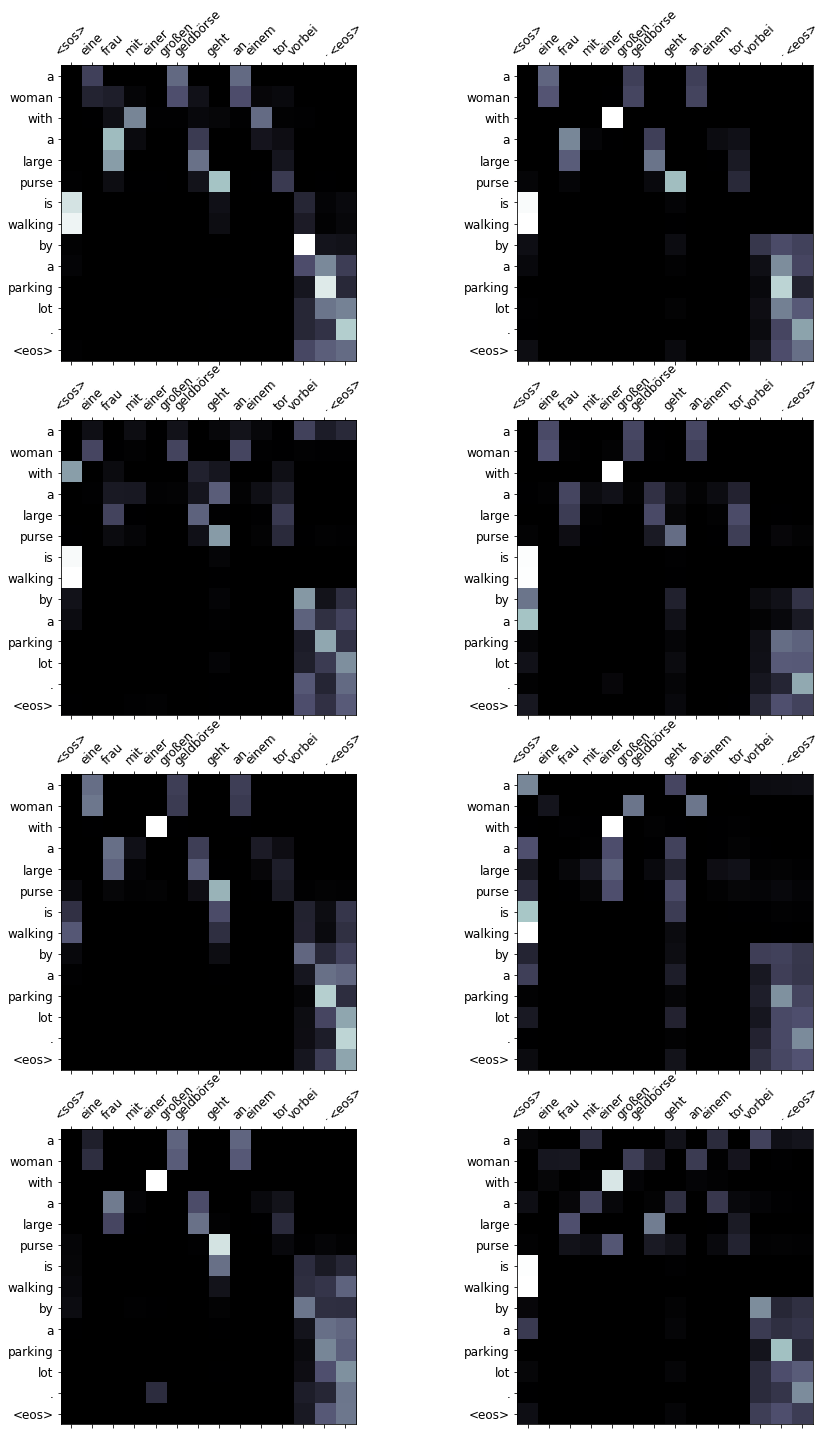

In [41]:
display_attention(src, translation, attention)

In [42]:
# 예시 2
example_idx = 10

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print(f"src = {src}")
print(f"trg = {trg}")

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [43]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f"predicted trg = {translation}")

predicted trg = ['a', 'mother', 'and', 'her', 'daughter', 'are', 'getting', 'her', 'haircut', 'at', 'a', 'small', 'square', '.', '<eos>']


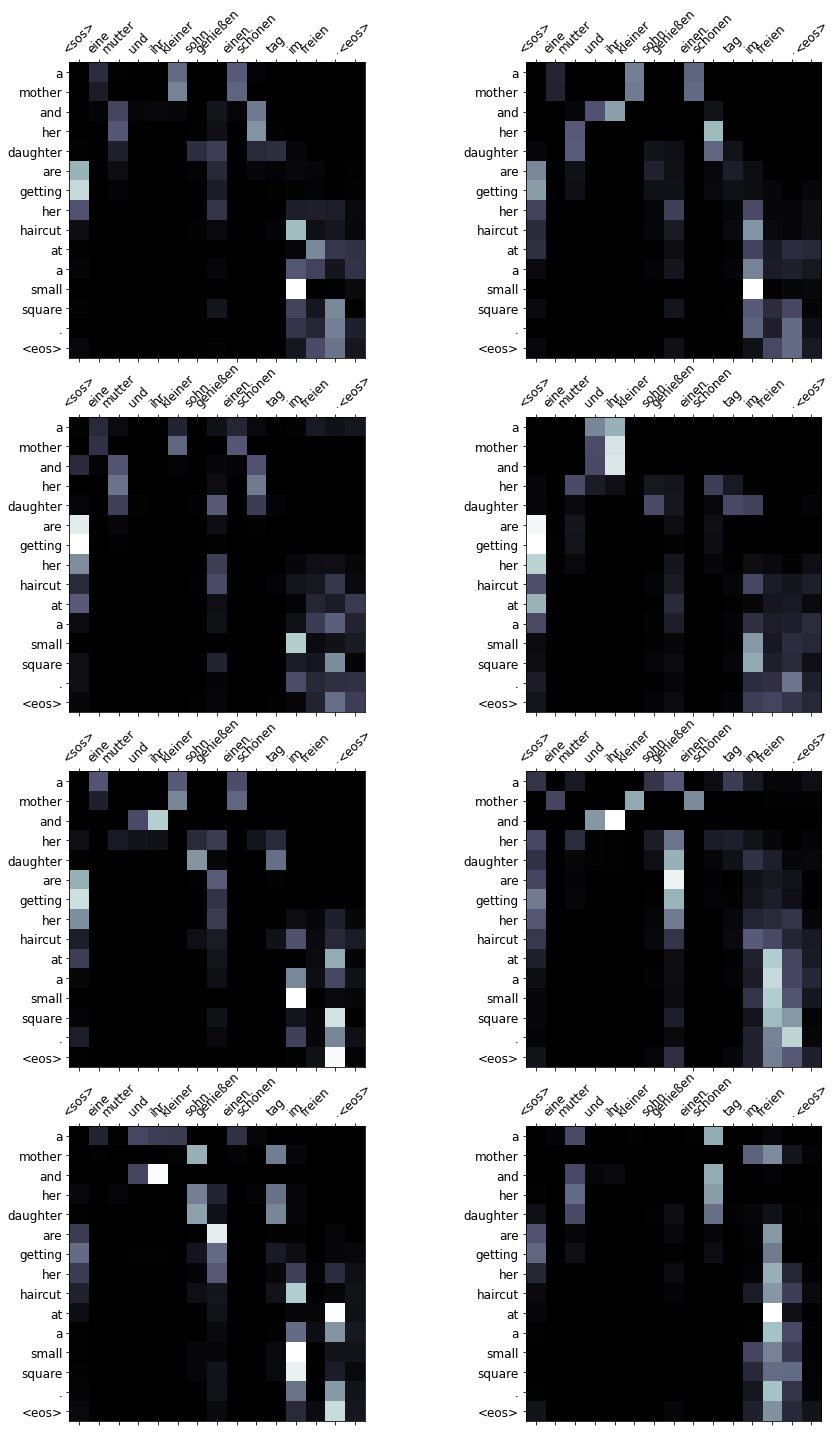

In [44]:
display_attention(src, translation, attention)